In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


def weights_init_normal(m):
    """Initializes the weight and bias of the model.

    Args:
        m: A torch model to initialize.

    Returns:
        None.
    """
    
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.2)
        torch.nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    """FR-Train generator (classifier).
    
    This class is for defining the structure of FR-Train generator (classifier). 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes Generator with torch components."""
        
        super(Generator, self).__init__()

    
        def block(in_feat, out_feat, normalize=True):
            """Defines a block with torch components.
            
                Args:
                    in_feat: An integer value for the size of the input feature.
                    out_feat: An integer value for the size of the output feature.
                    normalize: A boolean indicating whether normalization is needed.
                    
                Returns:
                    The stacked layer.
            """
            
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
#             *block(3, 32, normalize=False),
#             nn.Linear(32, 1),
#             nn.Tanh()
            nn.Linear(3,1)
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted label (y_hat) for the given input data.
        """
        
        output = self.model(input_data)
        return output


class DiscriminatorF(nn.Module):
    """FR-Train fairness discriminator.
    
    This class is for defining structure of FR-Train fairness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorF with torch components."""
        
        super(DiscriminatorF, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1,1),
            nn.Sigmoid(),
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
            
        Returns:
            The predicted sensitive attribute for the given input data.
        """
        
        predicted_z = self.model(input_data)
        return predicted_z
    

class DiscriminatorR(nn.Module):
    """FR-Train robustness discriminator.
    
    This class is for defining the structure of FR-Train robustness discriminator. 
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """
    
    def __init__(self):
        """Initializes DiscriminatorR with torch components."""
        
        super(DiscriminatorR, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(4, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.
        
        Args: 
            input_data: The input data.
        
        Returns:
            The predicted indicator (whether the input data is clean or poisoned) 
            for the given input data.
        """
        
        validity = self.model(input_data)
        return validity
    

def test_model(model_, X, y, s1):
    """Tests the performance of a model.

    Args:
        model_: A model to test.
        X: Input features of test data.
        y: True label (1-D) of test data.
        s1: Sensitive attribute (1-D) of test data.

    Returns:
        The test accuracy and disparate impact of the model.
    """
    
    model_.eval()
    
    y_hat = model_(X).squeeze()
    prediction = (y_hat > 0.0).int().squeeze()
    y = (y > 0.0).int()

    z_0_mask = (s1 == 0.0)
    z_1_mask = (s1 == 1.0)
    z_0 = int(torch.sum(z_0_mask))
    z_1 = int(torch.sum(z_1_mask))

    Pr_y_hat_1_z_0 = float(torch.sum((prediction == 1)[z_0_mask])) / z_0
    Pr_y_hat_1_z_1 = float(torch.sum((prediction == 1)[z_1_mask])) / z_1
    
    y_1_z_0_mask = (y == 1.0) & (s1 == 0.0)
    y_1_z_1_mask = (y == 1.0) & (s1 == 1.0)
    y_1_z_0 = int(torch.sum(y_1_z_0_mask))
    y_1_z_1 = int(torch.sum(y_1_z_1_mask))

    Pr_y_hat_1_y_1_z_0 = float(torch.sum((prediction == 1)[y_1_z_0_mask])) / y_1_z_0
    Pr_y_hat_1_y_1_z_1 = float(torch.sum((prediction == 1)[y_1_z_1_mask])) / y_1_z_1
    
    y_hat_neq_y = float(torch.sum((prediction == y.int())))

    test_acc = torch.sum(prediction == y.int()).float() / len(y)
    print("Test accuracy: {}".format(test_acc))
    print("P(y_hat=1 | z=0) = {:.3f}, P(y_hat=1 | z=1) = {:.3f}".format(Pr_y_hat_1_z_0, Pr_y_hat_1_z_1))
    print("P(y_hat=1 | y=1, z=0) = {:.3f}, P(y_hat=1 | y=1, z=1) = {:.3f}".format(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1))
    min_dp = min(Pr_y_hat_1_z_0, Pr_y_hat_1_z_1)
    max_dp = max(Pr_y_hat_1_z_0, Pr_y_hat_1_z_1)
    print("Disparate Impact ratio = {:.3f}".format(min_dp/max_dp))
#     min_eo = min(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     max_eo = max(Pr_y_hat_1_y_1_z_0, Pr_y_hat_1_y_1_z_1)
#     print("Equal Opportunity ratio = {:.3f}".format(min_eo/max_eo))
    return test_acc, min_dp/max_dp



# FR-Train clean

--------------------- Number of Data -------------------------
Train data : 1800, Validation data : 200, Test data : 1000 
--------------------------------------------------------------
[Lambda_f: 0.100000] [Epoch 0/4000] [D_F loss: 0.686340] [D_R loss: 0.716233] [G loss: 0.465272]
[Lambda_f: 0.100000] [Epoch 200/4000] [D_F loss: 0.584360] [D_R loss: 0.680139] [G loss: 0.312735]
[Lambda_f: 0.100000] [Epoch 400/4000] [D_F loss: 0.577822] [D_R loss: 0.673043] [G loss: 0.312282]
[Lambda_f: 0.100000] [Epoch 600/4000] [D_F loss: 0.625694] [D_R loss: 0.659043] [G loss: -0.175348]
[Lambda_f: 0.100000] [Epoch 800/4000] [D_F loss: 0.607116] [D_R loss: 0.644620] [G loss: -0.165607]
[Lambda_f: 0.100000] [Epoch 1000/4000] [D_F loss: 0.598278] [D_R loss: 0.633544] [G loss: -0.157219]
[Lambda_f: 0.100000] [Epoch 1200/4000] [D_F loss: 0.596344] [D_R loss: 0.625003] [G loss: -0.150191]
[Lambda_f: 0.100000] [Epoch 1400/4000] [D_F loss: 0.596106] [D_R loss: 0.617380] [G loss: -0.144472]
[Lambda_f: 0.100

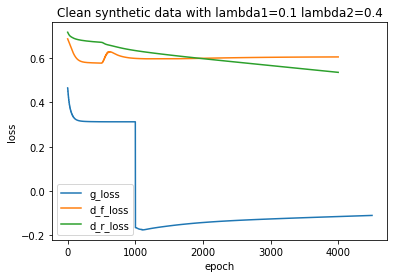

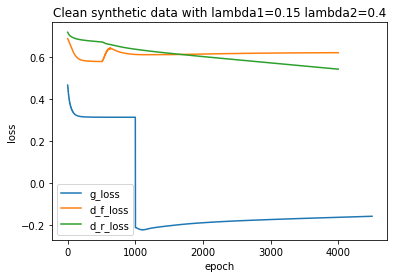

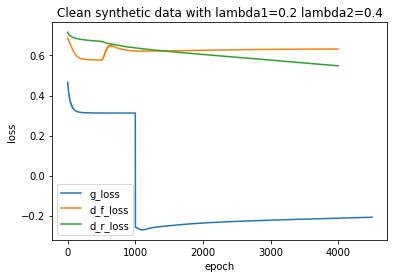

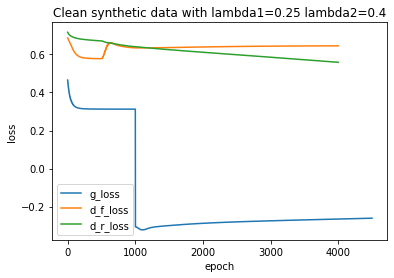

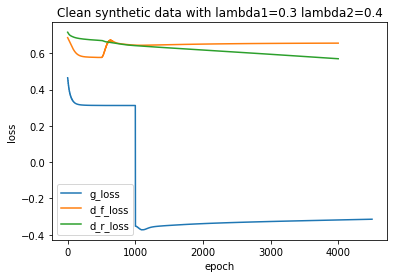

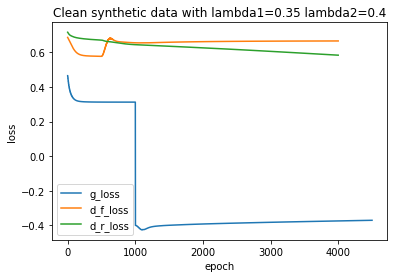

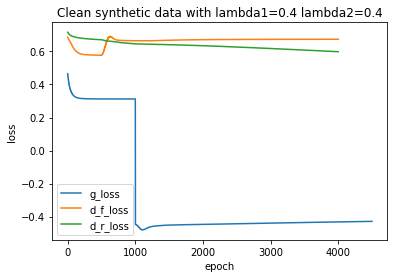

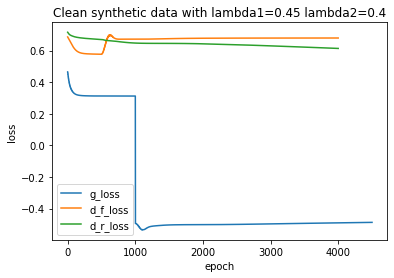

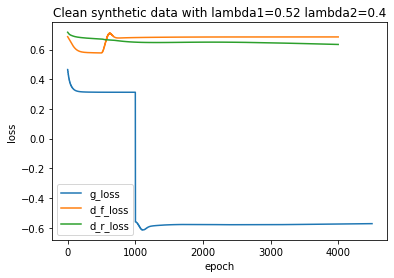

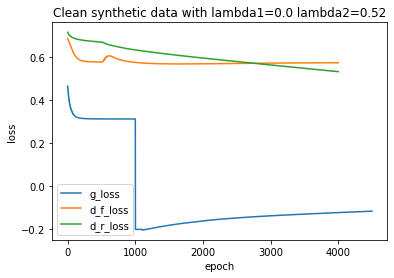

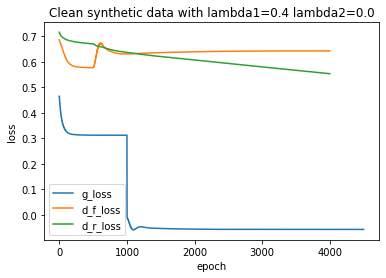

In [5]:
import time
import sys, os
import numpy as np
import math

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import matplotlib.pyplot as plt

from argparse import Namespace



# a namespace object which contains some of the hyperparameters
opt = Namespace(num_train=2000, num_val1=200, num_val2=500, num_test=1000)



num_train = opt.num_train
num_val1 = opt.num_val1
num_val2 = opt.num_val2
num_test = opt.num_test

X = np.load('X_synthetic.npy') # Input features
y = np.load('y_synthetic.npy') # Labels
s1 = np.load('s1_synthetic.npy') # Sensitive features

X = torch.FloatTensor(X)
y = torch.FloatTensor(y)
s1 = torch.FloatTensor(s1)

X_train = X[:num_train - num_val1]
y_train = y[:num_train - num_val1] # Clean label
s1_train = s1[:num_train - num_val1]


X_val = X[num_train: num_train + num_val1]
y_val = y[num_train: num_train + num_val1]
s1_val = s1[num_train: num_train + num_val1]

# Currently not used
# X_val2 = X[num_train + num_val1 : num_train + num_val1 + num_val2]
# y_val2 = y[num_train + num_val1 : num_train + num_val1 + num_val2]
# s1_val2 = s1[num_train + num_val1 : num_train + num_val1 + num_val2]

X_test = X[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
y_test = y[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
s1_test = s1[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]

XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)



print("--------------------- Number of Data -------------------------" )
print(
    "Train data : %d, Validation data : %d, Test data : %d "
    % (len(y_train), len(y_val), len(y_test))
)
print("--------------------------------------------------------------")

def get_tensor_vals(tensors):
    ans = []
    for t in tensors:
        ans.append(t.detach().numpy().item())
    return ans

def train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f, lambda_r, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.

      Args:
        train_tensors: Training data.
        val_tensors: Clean validation data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set,
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        lambda_r: The tuning knob for L_3 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.

      Returns:
        Information about the tuning knobs (lambda_f, lambda_r),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """

    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train

    XS_val = val_tensors.XS_val
    y_val = val_tensors.y_val
    s1_val = val_tensors.s1_val

    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test

    # Saves return values here
    test_result = []

    val = train_opt.val  # Number of data points in validation set
    k = train_opt.k  # Updates ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    # Changes the input validation data to an appropriate shape for the training
    XSY_val = torch.cat([XS_val, y_val.reshape((y_val.shape[0], 1))], dim=1)

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses = []
    d_f_losses = []
    d_r_losses = []
    clean_test_result = []

    bce_loss = torch.nn.BCELoss()

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()
    discriminator_R = DiscriminatorR()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)
    discriminator_R.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)
    optimizer_D_R = torch.optim.SGD(discriminator_R.parameters(), lr=train_opt.lr_r)

    XSY_val_data = XSY_val[:val]

    train_len = XS_train.shape[0]
    val_len = XSY_val.shape[0]

    # Ground truths using in Disriminator_R
    Tensor = torch.FloatTensor
    valid = Variable(Tensor(train_len, 1).fill_(1.0), requires_grad=False)
    generated = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    fake = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    clean = Variable(Tensor(val_len, 1).fill_(1.0), requires_grad=False)

    r_weight = torch.ones_like(y_train, requires_grad=False).float()
    r_ones = torch.ones_like(y_train, requires_grad=False).float()

    start_time = time.time()

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        if epoch % k == 0 or epoch < 500:
            optimizer_G.zero_grad()

        gen_y = generator(XS_train)
        gen_data = torch.cat([XS_train, gen_y.detach().reshape((gen_y.shape[0], 1))], dim=1)

        # -----------------------------
        #  Trains Fairness Discriminator
        # -----------------------------

        optimizer_D_F.zero_grad()

        # Discriminator_F tries to distinguish the sensitive groups by using the output of the generator.
        d_f_loss = bce_loss(discriminator_F(gen_y.detach()), s1_train.reshape((gen_y.shape[0], 1)))
        d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        optimizer_D_F.step()

        # ---------------------------------
        #  Trains Robustness Discriminator
        # ---------------------------------
        optimizer_D_R.zero_grad()

        # Discriminator_R tries to distinguish whether the input is from the validation data or the generated data from generator.
        clean_loss = bce_loss(discriminator_R(XSY_val_data), clean)
        poison_loss = bce_loss(discriminator_R(gen_data.detach()), fake)
        d_r_loss = 0.5 * (clean_loss + poison_loss)

        d_r_loss.backward()
        d_r_losses.append(d_r_loss)
        optimizer_D_R.step()

        # ---------------------
        #  Updates Generator
        # ---------------------

        # Loss measures generator's ability to fool the discriminators
        if epoch < 500:
            g_loss = bce_loss((torch.tanh(gen_y) + 1) / 2, (y_train.reshape((gen_y.shape[0], 1)) + 1) / 2)
            g_loss.backward()
            g_losses.append(g_loss)
            optimizer_G.step()

        elif epoch % k == 0:
            r_decision = discriminator_R(gen_data)
            r_gen = bce_loss(r_decision, generated)

            # ------------------------------
            #  Re-weights using output of D_R
            # ------------------------------

            if epoch % 100 == 0:
                loss_ratio = (g_losses[-1] / d_r_losses[-1]).detach()
                a = 1 / (1 + torch.exp(-(loss_ratio - 3)))
                b = 1 - a
                r_weight_tmp = r_decision.detach().squeeze()
                r_weight = a * r_weight_tmp + b * r_ones

            f_cost = F.binary_cross_entropy(discriminator_F(gen_y), s1_train.reshape((gen_y.shape[0], 1)), reduction="none").squeeze()
            g_cost = F.binary_cross_entropy_with_logits(gen_y.squeeze(), (y_train.squeeze() + 1) / 2,
                                                        reduction="none").squeeze()

            f_gen = torch.mean(f_cost * r_weight)
            g_loss = (1 - lambda_f - lambda_r) * torch.mean(g_cost * r_weight) - lambda_r * r_gen - lambda_f * f_gen

            g_loss.backward()
            optimizer_G.step()

        g_losses.append(g_loss)

        if epoch % 200 == 0:
            print(
                "[Lambda_f: %1f] [Epoch %d/%d] [D_F loss: %f] [D_R loss: %f] [G loss: %f]"
                % (lambda_f, epoch, n_epochs, d_f_losses[-1], d_r_losses[-1], g_losses[-1])
            )

    training_time = time.time() - start_time
    g_losses = get_tensor_vals(g_losses)
    d_f_losses = get_tensor_vals(d_f_losses)
    d_r_losses = get_tensor_vals(d_r_losses)
    #     torch.save(generator.state_dict(), './FR-Train_on_clean_synthetic.pth')
    plt.figure()
    plt.title(f'Clean synthetic data with lambda1={lambda_f} lambda2={lambda_r}')
    plt.plot(g_losses, label='g_loss')
    plt.plot(d_f_losses, label='d_f_loss')
    plt.plot(d_r_losses, label='d_r_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.show()

    start_time = time.time()
    tmp = test_model(generator, XS_test, y_test, s1_test)
    testing_time = time.time() - start_time
    test_result.append([lambda_f, lambda_r, tmp[0].item(), tmp[1]])

    return test_result, training_time, testing_time

train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val)
test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

train_opt = Namespace(val=len(y_val), n_epochs=4000, k=3, lr_g=0.005, lr_f=0.01, lr_r=0.001)
seed = 1


def hyperparameter_search():
    lambda_f_set = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.52]  # Lambda value for the fairness discriminator of FR-Train.
    lambda_r = 0.4  # Lambda value for the robustness discriminator of FR-Train.
    train_result = []
    times = []

    for lambda_f in lambda_f_set:
        results, tr_time, te_time = train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f=lambda_f,
                                                lambda_r=lambda_r, seed=seed)
        train_result.append(results)
        times.append([tr_time, te_time])

    print("-----------------------------------------------------------------------------------")
    print("------------------ Training Results of FR-Train on clean data ------------------")
    for i in range(len(train_result)):
        print(
            "[Lambda_f: %.2f] [Lambda_r: %.2f] Accuracy : %.3f, Disparate Impact : %.3f, Training time : %.3f s, Testing time : %.3f s "
            % (train_result[i][0][0], train_result[i][0][1], train_result[i][0][2], train_result[i][0][3], times[i][0],
               times[i][1])
        )
    print("-----------------------------------------------------------------------------------")


def ablation_test(lambda_f, lambda_r):
    results, tr_time, te_time = train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f=lambda_f,
                                            lambda_r=lambda_r, seed=seed)
    train_result = []
    times = []
    train_result.append(results)
    times.append([tr_time, te_time])

    print("-----------------------------------------------------------------------------------")
    print("------------------ Training Results of FR-Train on clean data ------------------")
    for i in range(len(train_result)):
        print(
            "[Lambda_f: %.2f] [Lambda_r: %.2f] Accuracy : %.3f, Disparate Impact : %.3f, Training time : %.3f s, Testing time : %.3f s "
            % (train_result[i][0][0], train_result[i][0][1], train_result[i][0][2], train_result[i][0][3], times[i][0],
               times[i][1])
        )
    print("-----------------------------------------------------------------------------------")

hyperparameter_search()
ablation_test(0.0, 0.52)
ablation_test(0.4, 0.0)
plt.show()

## FR-train poisoned

--------------------- Number of Data -------------------------
Train data : 1800, Validation data : 200, Test data : 1000 
--------------------------------------------------------------
[Lambda: 0.100000] [Epoch 0/10000] [D_F loss: 0.686340] [D_R loss: 0.716233] [G loss: 0.060358]
[Lambda: 0.100000] [Epoch 200/10000] [D_F loss: 0.682480] [D_R loss: 0.705211] [G loss: 0.057829]
[Lambda: 0.100000] [Epoch 400/10000] [D_F loss: 0.679608] [D_R loss: 0.698599] [G loss: 0.057678]
[Lambda: 0.100000] [Epoch 600/10000] [D_F loss: 0.672426] [D_R loss: 0.689106] [G loss: -0.083196]
[Lambda: 0.100000] [Epoch 800/10000] [D_F loss: 0.675747] [D_R loss: 0.686940] [G loss: -0.078719]
[Lambda: 0.100000] [Epoch 1000/10000] [D_F loss: 0.674420] [D_R loss: 0.684453] [G loss: -0.074216]
[Lambda: 0.100000] [Epoch 1200/10000] [D_F loss: 0.673476] [D_R loss: 0.682800] [G loss: -0.070523]
[Lambda: 0.100000] [Epoch 1400/10000] [D_F loss: 0.672513] [D_R loss: 0.681618] [G loss: -0.067542]
[Lambda: 0.100000] [Epoc

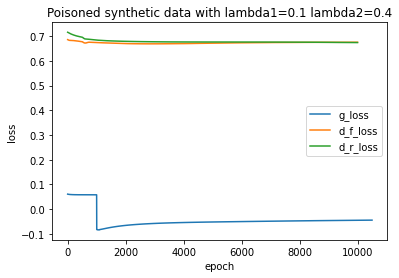

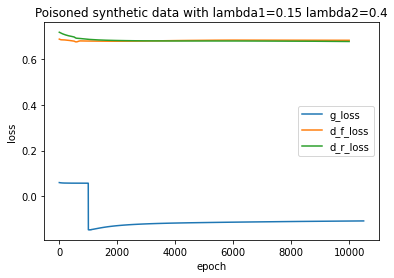

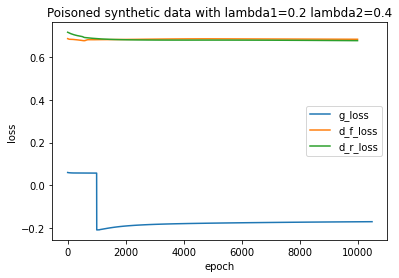

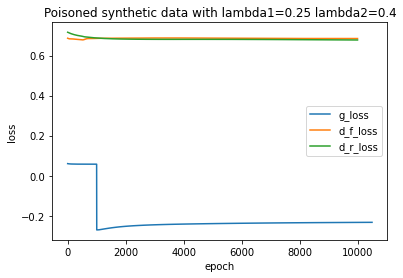

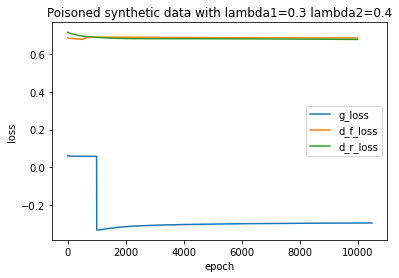

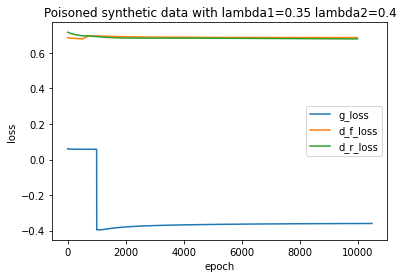

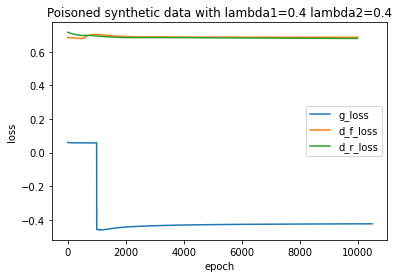

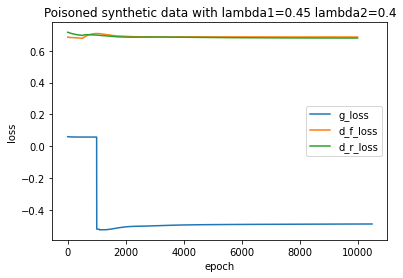

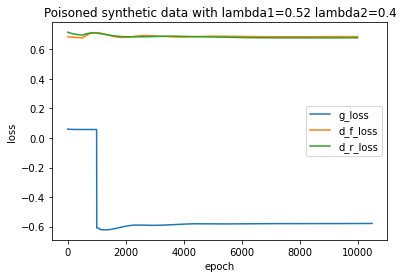

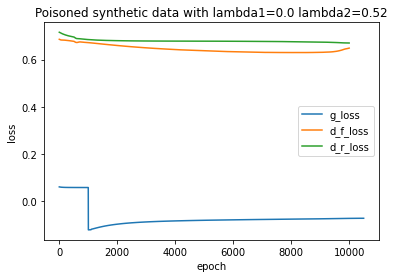

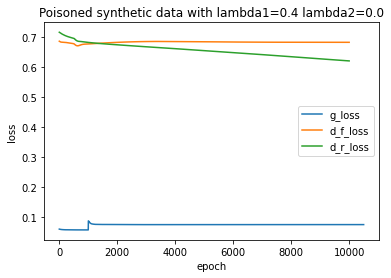

In [6]:
import sys, os
import numpy as np
import math
import time
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import matplotlib.pyplot as plt

from argparse import Namespace

opt = Namespace(num_train=2000, num_val1=200, num_val2=500, num_test=1000)


num_train = opt.num_train
num_val1 = opt.num_val1
num_val2 = opt.num_val2
num_test = opt.num_test

X = np.load('X_synthetic.npy') # Input features
y = np.load('y_synthetic.npy') # Original labels
y_poi = np.load('y_poi.npy') # Poisoned train labels
s1 = np.load('s1_synthetic.npy') # Sensitive features

X = torch.FloatTensor(X)
y = torch.FloatTensor(y)
y_poi = torch.FloatTensor(y_poi)
s1 = torch.FloatTensor(s1)

X_train = X[:num_train - num_val1]
y_train = y_poi[:num_train - num_val1] # Poisoned label
s1_train = s1[:num_train - num_val1]

X_val = X[num_train: num_train + num_val1]
y_val = y[num_train: num_train + num_val1]
s1_val = s1[num_train: num_train + num_val1]

# Currently not used
# X_val2 = X[num_train + num_val1 : num_train + num_val1 + num_val2]
# y_val2 = y[num_train + num_val1 : num_train + num_val1 + num_val2]
# s1_val2 = s1[num_train + num_val1 : num_train + num_val1 + num_val2]

X_test = X[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
y_test = y[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
s1_test = s1[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]

XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)



print("--------------------- Number of Data -------------------------" )
print(
    "Train data : %d, Validation data : %d, Test data : %d "
    % (len(y_train), len(y_val), len(y_test))
)
print("--------------------------------------------------------------")

def get_tensor_vals(tensors):
    ans = []
    for t in tensors:
        ans.append(t.detach().numpy().item())
    return ans


def train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f, lambda_r, seed):
    """
      Trains FR-Train by using the classes in FRTrain_arch.py.

      Args:
        train_tensors: Training data.
        val_tensors: Clean validation data.
        test_tensors: Test data.
        train_opt: Options for the training. It currently contains size of validation set,
                number of epochs, generator/discriminator update ratio, and learning rates.
        lambda_f: The tuning knob for L_2 (ref: FR-Train paper, Section 3.3).
        lambda_r: The tuning knob for L_3 (ref: FR-Train paper, Section 3.3).
        seed: An integer value for specifying torch random seed.

      Returns:
        Information about the tuning knobs (lambda_f, lambda_r),
        the test accuracy of the trained model, and disparate impact of the trained model.
    """

    XS_train = train_tensors.XS_train
    y_train = train_tensors.y_train
    s1_train = train_tensors.s1_train

    XS_val = val_tensors.XS_val
    y_val = val_tensors.y_val
    s1_val = val_tensors.s1_val

    XS_test = test_tensors.XS_test
    y_test = test_tensors.y_test
    s1_test = test_tensors.s1_test

    # Saves return values here
    test_result = []

    val = train_opt.val  # Number of data points in validation set
    k = train_opt.k  # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    # Changes the input validation data to an appropriate shape for the training
    XSY_val = torch.cat([XS_val, y_val.reshape((y_val.shape[0], 1))], dim=1)

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses = []
    d_f_losses = []
    d_r_losses = []
    clean_test_result = []

    bce_loss = torch.nn.BCELoss()

    # Initializes generator and discriminator
    generator = Generator()
    discriminator_F = DiscriminatorF()
    discriminator_R = DiscriminatorR()

    # Initializes weights
    torch.manual_seed(seed)
    generator.apply(weights_init_normal)
    discriminator_F.apply(weights_init_normal)
    discriminator_R.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)
    optimizer_D_F = torch.optim.SGD(discriminator_F.parameters(), lr=train_opt.lr_f)
    optimizer_D_R = torch.optim.SGD(discriminator_R.parameters(), lr=train_opt.lr_r)

    XSY_val_data = XSY_val[:val]

    train_len = XS_train.shape[0]
    val_len = XSY_val.shape[0]

    # Ground truths using in Disriminator_R
    Tensor = torch.FloatTensor
    valid = Variable(Tensor(train_len, 1).fill_(1.0), requires_grad=False)
    generated = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    fake = Variable(Tensor(train_len, 1).fill_(0.0), requires_grad=False)
    clean = Variable(Tensor(val_len, 1).fill_(1.0), requires_grad=False)

    r_weight = torch.ones_like(y_train, requires_grad=False).float()
    r_ones = torch.ones_like(y_train, requires_grad=False).float()

    start_time = time.time()

    for epoch in range(n_epochs):

        # -------------------
        #  Forwards Generator
        # -------------------
        if epoch % k == 0 or epoch < 500:
            optimizer_G.zero_grad()

        gen_y = generator(XS_train)
        gen_data = torch.cat([XS_train, gen_y.reshape((gen_y.shape[0], 1))], dim=1)

        # -------------------------------
        #  Trains Fairness Discriminator
        # -------------------------------

        optimizer_D_F.zero_grad()

        # Discriminator_F tries to distinguish the sensitive groups by using the output of the generator.
        d_f_loss = bce_loss(discriminator_F(gen_y.detach()), s1_train.reshape((gen_y.shape[0], 1)))
        d_f_loss.backward()
        d_f_losses.append(d_f_loss)
        optimizer_D_F.step()

        # ---------------------------------
        #  Trains Robustness Discriminator
        # ---------------------------------

        optimizer_D_R.zero_grad()

        # Discriminator_R tries to distinguish whether the input is from the validation data or the generated data from generator.
        clean_loss = bce_loss(discriminator_R(XSY_val_data), clean)
        poison_loss = bce_loss(discriminator_R(gen_data.detach()), fake)
        d_r_loss = 0.5 * (clean_loss + poison_loss)

        d_r_loss.backward()
        d_r_losses.append(d_r_loss)
        optimizer_D_R.step()

        # ---------------------
        #  Updates Generator
        # ---------------------

        if epoch < 500:
            g_loss = 0.1 * bce_loss((torch.tanh(gen_y) + 1) / 2, (y_train.reshape((gen_y.shape[0], 1)) + 1) / 2)
            g_loss.backward()
            g_losses.append(g_loss)
            optimizer_G.step()
        elif epoch % k == 0:
            r_decision = discriminator_R(gen_data)
            r_gen = bce_loss(r_decision, generated)

            # ---------------------------------
            #  Re-weights using output of D_R
            # ---------------------------------
            if epoch % 100 == 0:
                loss_ratio = (g_losses[-1] / d_r_losses[-1]).detach()
                a = 1 / (1 + torch.exp(-(loss_ratio - 3)))
                b = 1 - a
                r_weight_tmp = r_decision.detach().squeeze()
                r_weight = a * r_weight_tmp + b * r_ones

            f_cost = F.binary_cross_entropy(discriminator_F(gen_y), s1_train.reshape((gen_y.shape[0], 1)), reduction="none").squeeze()
            g_cost = F.binary_cross_entropy_with_logits(gen_y.squeeze(), (y_train.squeeze() + 1) / 2,
                                                        reduction="none").squeeze()

            f_gen = torch.mean(f_cost * r_weight)
            g_loss = (1 - lambda_f - lambda_r) * torch.mean(g_cost * r_weight) - lambda_f * f_gen - lambda_r * r_gen

            g_loss.backward()
            optimizer_G.step()

        g_losses.append(g_loss)

        if epoch % 200 == 0:
            print(
                "[Lambda: %1f] [Epoch %d/%d] [D_F loss: %f] [D_R loss: %f] [G loss: %f]"
                % (lambda_f, epoch, n_epochs, d_f_losses[-1], d_r_losses[-1], g_losses[-1])
            )

    training_time = time.time() - start_time

    g_losses = get_tensor_vals(g_losses)
    d_f_losses = get_tensor_vals(d_f_losses)
    d_r_losses = get_tensor_vals(d_r_losses)
    #     torch.save(generator.state_dict(), './FR-Train_on_clean_synthetic.pth')
    plt.figure()
    plt.title(f'Poisoned synthetic data with lambda1={lambda_f} lambda2={lambda_r}')
    plt.plot(g_losses, label='g_loss')
    plt.plot(d_f_losses, label='d_f_loss')
    plt.plot(d_r_losses, label='d_r_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.show()

    start_time = time.time()
    tmp = test_model(generator, XS_test, y_test, s1_test)
    testing_time = time.time() - start_time
    test_result.append([lambda_f, lambda_r, tmp[0].item(), tmp[1]])

    return test_result, training_time, testing_time


train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val)
test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)

train_opt = Namespace(val=len(y_val), n_epochs=10000, k=5, lr_g=0.001, lr_f=0.001, lr_r=0.001)
seed = 1


def hyperparameter_search():
    lambda_f_set = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.52]  # Lambda value for the fairness discriminator of FR-Train.
    lambda_r = 0.4  # Lambda value for the robustness discriminator of FR-Train.
    train_result = []
    times = []

    for lambda_f in lambda_f_set:
        results, tr_time, te_time = train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f=lambda_f,
                                                lambda_r=lambda_r, seed=seed)
        train_result.append(results)
        times.append([tr_time, te_time])

    print("-----------------------------------------------------------------------------------")
    print("------------------ Training Results of FR-Train on poisoned data ------------------")
    for i in range(len(train_result)):
        print(
            "[Lambda_f: %.2f] [Lambda_r: %.2f] Accuracy : %.3f, Disparate Impact : %.3f, Training time : %.3f s, Testing time : %.3f s "
            % (train_result[i][0][0], train_result[i][0][1], train_result[i][0][2], train_result[i][0][3], times[i][0],
               times[i][1])
        )
    print("-----------------------------------------------------------------------------------")


def ablation_test(lambda_f, lambda_r):
    results, tr_time, te_time = train_model(train_tensors, val_tensors, test_tensors, train_opt, lambda_f=lambda_f,
                                            lambda_r=lambda_r, seed=seed)
    train_result = []
    times = []
    train_result.append(results)
    times.append([tr_time, te_time])

    print("-----------------------------------------------------------------------------------")
    print("------------------ Training Results of FR-Train on poisoned data ------------------")
    for i in range(len(train_result)):
        print(
            "[Lambda_f: %.2f] [Lambda_r: %.2f] Accuracy : %.3f, Disparate Impact : %.3f, Training time : %.3f s, Testing time : %.3f s "
            % (train_result[i][0][0], train_result[i][0][1], train_result[i][0][2], train_result[i][0][3], times[i][0],
               times[i][1])
        )
    print("-----------------------------------------------------------------------------------")


hyperparameter_search()
ablation_test(0.0, 0.52)
ablation_test(0.4, 0.0)
plt.show()